In [1]:
# Predicting stock price moves with Logistic Regression
import warnings
warnings.filterwarnings('ignore')

In [3]:
from pathlib import Path
import sys, os
from time import time

import pandas as pd
import numpy as np

from scipy.stats import spearmanr

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
# The below is the Python file saved in the same location as this notebook. It has the class called MultipleTimeSeriesCV
from utils import MultipleTimeSeriesCV

In [5]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [6]:
YEAR = 252

In [8]:
# Load Data
with pd.HDFStore('/Volumes/My Book/Data_Analysis/Data/data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))
data = data.drop([c for c in data.columns if 'year' in c or 'lag' in c], axis=1)

In [9]:
# Select Investment Universe
data = data[data.dollar_vol_rank<100]

In [11]:
# Create Model Data
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_discretionary'], axis=1)

In [12]:
# Logistic Regression
# Define cross-validation parameters
train_period_length = 63
test_period_length = 10
lookahead =1
n_splits = int(3 * YEAR/test_period_length)

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [13]:
target = f'target_{lookahead}d'

In [14]:
y.loc[:, 'label'] = (y[target] > 0).astype(int)
y.label.value_counts()

label
1    56594
0    53155
Name: count, dtype: int64

In [15]:
Cs = np.logspace(-5, 5, 11)

In [16]:
cols = ['C', 'date', 'auc', 'ic', 'pval']

In [17]:
%%time

# Run cross-validation

log_coeffs, log_scores, log_predictions = {}, [], []
for C in Cs:
    print(C)
    model = LogisticRegression(C=C,
                               fit_intercept=True,
                               random_state=42,
                               n_jobs=-1)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    ics = aucs = 0
    start = time()
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y.label.iloc[train_idx]
        pipe.fit(X=X_train, y=y_train)
        X_test, y_test = X.iloc[test_idx], y.label.iloc[test_idx]
        actuals = y[target].iloc[test_idx]
        if len(y_test) < 10 or len(np.unique(y_test)) < 2:
            continue
        y_score = pipe.predict_proba(X_test)[:, 1]
       
        auc = roc_auc_score(y_score=y_score, y_true=y_test)
        actuals = y[target].iloc[test_idx]
        ic, pval = spearmanr(y_score, actuals)

        log_predictions.append(y_test.to_frame('labels').assign(
            predicted=y_score, C=C, actuals=actuals))
        date = y_test.index.get_level_values('date').min()
        log_scores.append([C, date, auc, ic * 100, pval])
        coeffs.append(pipe.named_steps['model'].coef_)
        ics += ic
        aucs += auc
        if i % 10 == 0:
            print(f'\t{time()-start:5.1f} | {i:03} | {ics/i:>7.2%} | {aucs/i:>7.2%}')

    log_coeffs[C] = np.mean(coeffs, axis=0).squeeze()

1e-05
	 11.1 | 010 |  -1.38% |  49.73%
	 22.7 | 020 |   1.48% |  51.45%
	 34.0 | 030 |   2.60% |  51.76%
	 45.4 | 040 |   3.07% |  51.75%
	 56.9 | 050 |   4.00% |  52.36%
	 68.5 | 060 |   3.89% |  52.16%
	 80.1 | 070 |   4.67% |  52.53%
0.0001
	 11.5 | 010 |  -1.34% |  49.77%
	 22.9 | 020 |   1.54% |  51.46%
	 34.7 | 030 |   2.86% |  51.89%
	 47.4 | 040 |   3.06% |  51.76%
	 59.1 | 050 |   4.05% |  52.39%
	 70.6 | 060 |   3.96% |  52.19%
	 82.1 | 070 |   4.80% |  52.58%
0.001
	 11.6 | 010 |  -1.21% |  49.75%
	 23.0 | 020 |   1.49% |  51.31%
	 34.5 | 030 |   3.13% |  51.94%
	 46.0 | 040 |   2.73% |  51.56%
	 57.5 | 050 |   3.89% |  52.30%
	 68.9 | 060 |   4.04% |  52.17%
	 80.3 | 070 |   4.93% |  52.61%
0.01
	 11.5 | 010 |  -0.77% |  49.96%
	 23.0 | 020 |   1.39% |  51.18%
	 34.7 | 030 |   3.05% |  51.82%
	 46.2 | 040 |   2.69% |  51.47%
	 57.8 | 050 |   3.89% |  52.25%
	 69.2 | 060 |   4.07% |  52.12%
	 80.8 | 070 |   4.79% |  52.48%
0.1
	 11.7 | 010 |  -0.61% |  50.08%
	 23.3 | 020 | 

In [18]:
# Evaluate Results
log_scores = pd.DataFrame(log_scores, columns=cols)
log_scores.to_hdf('/Volumes/My Book/Data_Analysis/Data/data.h5', 'logistic/scores')

log_coeffs = pd.DataFrame(log_coeffs, index=X.columns).T
log_coeffs.to_hdf('/Volumes/My Book/Data_Analysis/Data/data.h5', 'logistic/coeffs')

log_predictions = pd.concat(log_predictions)
log_predictions.to_hdf('/Volumes/My Book/Data_Analysis/Data/data.h5', 'logistic/predictions')

In [19]:
log_scores = pd.read_hdf('/Volumes/My Book/Data_Analysis/Data/data.h5', 'logistic/scores')

In [20]:
log_scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   C       825 non-null    float64       
 1   date    825 non-null    datetime64[ns]
 2   auc     825 non-null    float64       
 3   ic      825 non-null    float64       
 4   pval    825 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 38.7 KB


In [21]:
log_scores.groupby('C').auc.describe()

,count,mean,std,min,25%,50%,75%,max
C,,,,,,,,
0.00001,75.0,0.523470,0.035749,0.422595,0.498303,0.521162,0.543090,0.617796
0.00010,75.0,0.524015,0.035370,0.436186,0.500576,0.523855,0.540868,0.628888
0.00100,75.0,0.524468,0.036894,0.450238,0.504088,0.520678,0.548698,0.650249
0.01000,75.0,0.523668,0.036965,0.444775,0.500314,0.519930,0.546441,0.652948
0.10000,75.0,0.522365,0.036782,0.439928,0.497179,0.520049,0.545662,0.640608
1.00000,75.0,0.522006,0.036816,0.438392,0.496833,0.519343,0.546742,0.637626
10.00000,75.0,0.521965,0.036822,0.438232,0.496804,0.519253,0.546814,0.637198
100.00000,75.0,0.521962,0.036820,0.438223,0.496799,0.519269,0.546818,0.637134
1000.00000,75.0,0.521961,0.036819,0.438232,0.496797,0.519278,0.546812,0.637117


In [22]:
# Plot Validation Scores
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)    
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9, s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

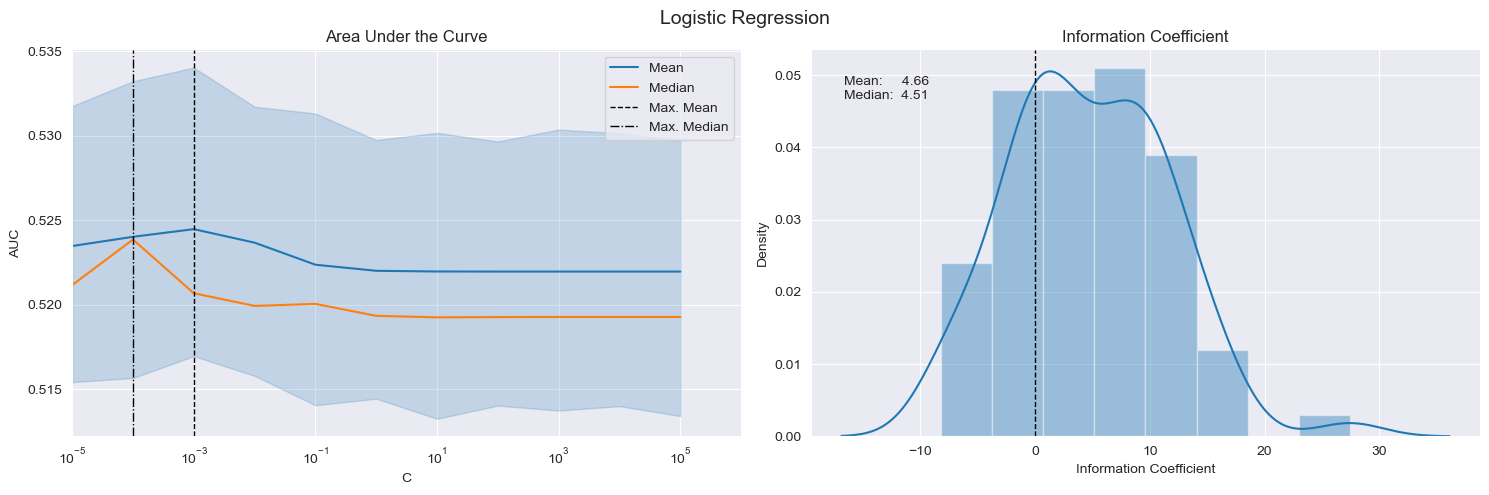

In [23]:
fig, axes= plt.subplots(ncols=2, figsize=(15, 5))

sns.lineplot(x='C', y='auc', data=log_scores, estimator=np.mean, label='Mean', ax=axes[0])
by_alpha = log_scores.groupby('C').auc.agg(['mean', 'median'])
best_auc = by_alpha['mean'].idxmax()
by_alpha['median'].plot(logx=True, ax=axes[0], label='Median', xlim=(10e-6, 10e5))
axes[0].axvline(best_auc, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(by_alpha['median'].idxmax(), ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_ylabel('AUC')
axes[0].set_xscale('log')
axes[0].set_title('Area Under the Curve')

plot_ic_distribution(log_scores[log_scores.C==best_auc], ax=axes[1])
axes[1].set_title('Information Coefficient')

fig.suptitle('Logistic Regression', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);